In [234]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Set random seed for reproducibility


In [235]:
torch.manual_seed(42)
np.random.seed(42)

Device configuration


In [236]:
device = "mps"
print(f"Using device: {device}")

Using device: mps


In [237]:
seq_len = 12

Load and prepare data


Create a unique location identifier and time key


In [238]:
data = pd.read_csv("./data/rnn_data.csv")
data.columns

Index(['location_name', 'location_id', 'Year', 'Month', 'crime_count',
       'arrest', 'domestic', 'weekday', 'weekend', 'morning', 'afternoon',
       'evening', 'night', 'holiday_num', 'num_days', 'arrest_rate',
       'domestic_rate', 'morning_rate', 'afternoon_rate', 'evening_rate',
       'night_rate', 'sin_month', 'cos_month', 'time_id', 'crime_pct_change'],
      dtype='object')

In [239]:
min_year = np.min(data["Year"].unique())
n_times = data["time_id"].nunique()
n_locations = data["location_id"].nunique()
location2idx = {location: i for i, location in enumerate(data["location_id"].unique())}
time2idx = {time: i for i, time in enumerate(data["time_id"].unique())}
data["location_idx"] = data["location_id"].map(location2idx)
data["time_idx"] = data["time_id"].map(time2idx)
data

,location_name,location_id,Year,Month,crime_count,arrest,domestic,weekday,weekend,morning,...,morning_rate,afternoon_rate,evening_rate,night_rate,sin_month,cos_month,time_id,crime_pct_change,location_idx,time_idx
0,Abandoned/Condemned Structure,1,2018,1,20,7,1,15,5,8,...,0.400000,0.300000,0.200000,0.100000,0.000000,1.000000e+00,24217,-0.166667,0,0
1,Abandoned/Condemned Structure,1,2018,2,20,7,0,18,2,11,...,0.550000,0.200000,0.100000,0.150000,0.500000,8.660254e-01,24218,0.000000,0,1
2,Abandoned/Condemned Structure,1,2018,3,24,12,1,14,10,10,...,0.416667,0.500000,0.083333,0.000000,0.866025,5.000000e-01,24219,0.200000,0,2
3,Abandoned/Condemned Structure,1,2018,4,27,10,3,17,10,8,...,0.296296,0.592593,0.037037,0.074074,1.000000,6.123234e-17,24220,0.125000,0,3
4,Abandoned/Condemned Structure,1,2018,5,36,20,2,30,6,11,...,0.305556,0.305556,0.277778,0.111111,0.866025,-5.000000e-01,24221,0.333333,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2428,Not Specified,99,2024,8,91,0,0,70,21,33,...,0.362637,0.505495,0.087912,0.043956,-0.500000,-8.660254e-01,24296,0.022472,31,79
2429,Not Specified,99,2024,9,59,0,0,47,12,24,...,0.406780,0.355932,0.101695,0.135593,-0.866025,-5.000000e-01,24297,-0.351648,31,80
2430,Not Specified,99,2024,10,73,0,0,65,8,31,...,0.424658,0.410959,0.068493,0.095890,-1.000000,-1.836970e-16,24298,0.237288,31,81
2431,Not Specified,99,2024,11,56,0,1,47,9,26,...,0.464286,0.357143,0.071429,0.107143,-0.866025,5.000000e-01,24299,-0.232877,31,82


In [240]:
features = [
    "crime_count",
    "crime_pct_change",
    "Year",
    "Month",
    "arrest_rate",
    "domestic_rate",
    "morning_rate",
    "evening_rate",
    "afternoon_rate",
    "night_rate",
    "num_days",
    "holiday_num",
    "sin_month",
    "cos_month",
]
n_features = len(features)
pivot_df = data.pivot(
    index="time_idx",
    columns="location_idx",
    values=features,
)
pivot_df = pivot_df.fillna(0)
train_size = int((len(pivot_df) - seq_len) - 12)
print(f"train_size: {train_size}")
# time_features = pd.DataFrame(index=pivot_df.index)
# time_features["holiday_num"] = data.groupby("time_idx")["holiday_count"].first()
# time_features["sin_month"] = data.groupby("time_idx")["sin_month"].first()
# time_features["cos_month"] = data.groupby("time_idx")["cos_month"].first()
pivot_df

train_size: 60


crime_count                                                      \
location_idx          0      1     2     3     4      5      6     7      8    
time_idx                                                                       
0                   20.0  518.0  18.0  49.0  20.0  115.0  189.0   1.0  143.0   
1                   20.0  504.0  29.0  58.0  16.0  108.0  179.0   1.0  139.0   
2                   24.0  566.0  23.0  33.0  26.0  123.0  228.0   0.0  149.0   
3                   27.0  563.0  26.0  40.0  20.0  118.0  246.0   0.0  170.0   
4                   36.0  628.0  31.0  50.0  41.0  133.0  215.0   0.0  165.0   
...                  ...    ...   ...   ...   ...    ...    ...   ...    ...   
79                  13.0  541.0  34.0   5.0   9.0   83.0  226.0  51.0  339.0   
80                   3.0  503.0  15.0  13.0  16.0   94.0  198.0  42.0  328.0   
81                  15.0  482.0  17.0  12.0  12.0  108.0  209.0  39.0  360.0   
82                  18.0  428.0  17.0  17.0  21.0   87.0  195.0  51.0  291.0   
83                  16.0  431.0  20.0  14.0  13.0   60.0  198.0  24.0  331.0   

                    ...     cos_month                                   \
location_idx    9   ...            22   23            24            25   
time_idx            ...                                                  
0             28.0  ...  0.000000e+00  0.0  1.000000e+00  1.000000e+00   
1             21.0  ...  8.660254e-01  0.0  8.660254e-01  8.660254e-01   
2             27.0  ...  5.000000e-01  0.0  5.000000e-01  5.000000e-01   
3             34.0  ...  6.123234e-17  0.0  6.123234e-17  6.123234e-17   
4             36.0  ... -5.000000e-01  0.0 -5.000000e-01 -5.000000e-01   
...            ...  ...           ...  ...           ...           ...   
79            20.0  ... -8.660254e-01  0.0 -8.660254e-01 -8.660254e-01   
80            15.0  ... -5.000000e-01  0.0 -5.000000e-01 -5.000000e-01   
81            21.0  ... -1.836970e-16  0.0 -1.836970e-16 -1.836970e-16   
82            11.0  ...  0.000000e+00  0.0  5.000000e-01  5.000000e-01   
83            15.0  ...  0.000000e+00  0.0  8.660254e-01  8.660254e-01   

                                                                      \
location_idx            26            27            28            29   
time_idx                                                               
0             1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
1             8.660254e-01  8.660254e-01  8.660254e-01  8.660254e-01   
2             5.000000e-01  5.000000e-01  5.000000e-01  5.000000e-01   
3             6.123234e-17  6.123234e-17  6.123234e-17  6.123234e-17   
4            -5.000000e-01 -5.000000e-01 -5.000000e-01 -5.000000e-01   
...                    ...           ...           ...           ...   
79           -8.660254e-01 -8.660254e-01 -8.660254e-01 -8.660254e-01   
80           -5.000000e-01 -5.000000e-01 -5.000000e-01 -5.000000e-01   
81           -1.836970e-16 -1.836970e-16 -1.836970e-16 -1.836970e-16   
82            5.000000e-01  5.000000e-01  5.000000e-01  5.000000e-01   
83            8.660254e-01  8.660254e-01  8.660254e-01  8.660254e-01   

                                          
location_idx            30            31  
time_idx                                  
0             1.000000e+00  1.000000e+00  
1             8.660254e-01  8.660254e-01  
2             5.000000e-01  5.000000e-01  
3             6.123234e-17  6.123234e-17  
4            -5.000000e-01 -5.000000e-01  
...                    ...           ...  
79           -8.660254e-01 -8.660254e-01  
80           -5.000000e-01 -5.000000e-01  
81           -1.836970e-16 -1.836970e-16  
82            5.000000e-01  5.000000e-01  
83            8.660254e-01  8.660254e-01  

[84 rows x 448 columns]

In [241]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = pivot_df.copy()
scaler = MinMaxScaler()
print(scaled_df.shape)
scaled_df[: train_size + seq_len] = scaler.fit_transform(
    scaled_df[: train_size + seq_len]
)
scaled_df[train_size + seq_len :] = scaler.transform(scaled_df[train_size + seq_len :])
scaled_df = pd.DataFrame(scaled_df, columns=pivot_df.columns)
scaled_df

(84, 448)


crime_count                                                    \
location_idx          0         1         2         3         4         5    
time_idx                                                                     
0               0.542857  0.552102  0.326531  0.836364  0.277778  0.612613   
1               0.542857  0.526508  0.551020  1.000000  0.166667  0.549550   
2               0.657143  0.639854  0.428571  0.545455  0.444444  0.684685   
3               0.742857  0.634369  0.489796  0.672727  0.277778  0.639640   
4               1.000000  0.753199  0.591837  0.854545  0.861111  0.774775   
...                  ...       ...       ...       ...       ...       ...   
79              0.342857  0.594150  0.653061  0.036364 -0.027778  0.324324   
80              0.057143  0.524680  0.265306  0.181818  0.166667  0.423423   
81              0.400000  0.486289  0.306122  0.163636  0.055556  0.549550   
82              0.485714  0.387569  0.306122  0.254545  0.305556  0.360360   
83              0.428571  0.393053  0.367347  0.200000  0.083333  0.117117   

                                                      ... cos_month            \
location_idx        6         7         8         9   ...        22        23   
time_idx                                              ...                       
0             0.546713  0.016667  0.202247  0.619048  ...  0.500000  0.464102   
1             0.512111  0.016667  0.187266  0.452381  ...  0.933013  0.464102   
2             0.681661  0.000000  0.224719  0.595238  ...  0.750000  0.464102   
3             0.743945  0.000000  0.303371  0.761905  ...  0.500000  0.464102   
4             0.636678  0.000000  0.284644  0.809524  ...  0.250000  0.464102   
...                ...       ...       ...       ...  ...       ...       ...   
79            0.674740  0.850000  0.936330  0.428571  ...  0.066987  0.464102   
80            0.577855  0.700000  0.895131  0.309524  ...  0.250000  0.464102   
81            0.615917  0.650000  1.014981  0.452381  ...  0.500000  0.464102   
82            0.567474  0.850000  0.756554  0.214286  ...  0.500000  0.464102   
83            0.577855  0.400000  0.906367  0.309524  ...  0.500000  0.464102   

                                                                          \
location_idx        24        25        26        27        28        29   
time_idx                                                                   
0             1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1             0.933013  0.933013  0.933013  0.933013  0.933013  0.933013   
2             0.750000  0.750000  0.750000  0.750000  0.750000  0.750000   
3             0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
4             0.250000  0.250000  0.250000  0.250000  0.250000  0.250000   
...                ...       ...       ...       ...       ...       ...   
79            0.066987  0.066987  0.066987  0.066987  0.066987  0.066987   
80            0.250000  0.250000  0.250000  0.250000  0.250000  0.250000   
81            0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
82            0.750000  0.750000  0.750000  0.750000  0.750000  0.750000   
83            0.933013  0.933013  0.933013  0.933013  0.933013  0.933013   

                                  
location_idx        30        31  
time_idx                          
0             1.000000  1.000000  
1             0.933013  0.933013  
2             0.750000  0.750000  
3             0.500000  0.500000  
4             0.250000  0.250000  
...                ...       ...  
79            0.066987  0.066987  
80            0.250000  0.250000  
81            0.500000  0.500000  
82            0.750000  0.750000  
83            0.933013  0.933013  

[84 rows x 448 columns]

In [242]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


def scale_by_feature_type(pivot_df, train_size, seq_len):
    scaled_df = pivot_df.copy()
    feature_types = pivot_df.columns.get_level_values(0).unique()
    scaler_ls = []
    for feature in feature_types:
        feature_cols = [col for col in pivot_df.columns if col[0] == feature]
        scaler = MinMaxScaler()
        feature_data = pivot_df[feature_cols]
        train_data = feature_data.iloc[: train_size + seq_len]
        scaler.fit(train_data)
        scaled_df[feature_cols] = scaler.transform(feature_data)
        scaler_ls.append(scaler)
    return scaled_df, scaler_ls


scaled_df, scaler_ls = scale_by_feature_type(pivot_df, train_size, seq_len)

In [243]:
import numpy as np
import pandas as pd


def create_sequences(feat_df, seq_length=12):
    X_seq = []
    y_vals = []
    loc_idx = []
    time_idx = []
    T = feat_df.shape[0]
    locations = feat_df.columns.get_level_values(1).unique()
    crime_feature = feat_df.columns.get_level_values(0)[
        0
    ]  # Assuming 'crime_count' is the first feature type
    for location in locations:
        location_data = feat_df.xs(location, axis=1, level=1)

        # Create sliding windows
        for i in range(T - seq_length):
            # Extract feature window for all features
            feature_window = location_data.iloc[
                i : i + seq_length
            ].values  # shape (seq_length, n_features)
            y_val = feat_df[(crime_feature, location)].iloc[i + seq_length]
            X_seq.append(feature_window)
            y_vals.append(y_val)
            loc_idx.append(location)
            time_idx.append(i)
    X_seq = np.array(X_seq)  # shape => (n_locations * n_times, seq_length, n_features)
    y_vals = np.array(y_vals)  # shape => (n_locations * n_times,)
    loc_idx = np.array(loc_idx)  # shape => (n_locations * n_times,)
    time_idx = np.array(time_idx)  # shape => (n_locations * n_times,)
    return X_seq, y_vals, loc_idx, time_idx


seq_length = 12
X_seq, y, loc_idx, time_idx = create_sequences(scaled_df, seq_length=seq_length)

print("X_seq shape:", X_seq.shape)  # (n_locations * n_times, seq_length, n_features)
print("y shape:", y.shape)  # (n_locations * n_times,)
print("loc_idx shape:", loc_idx.shape)  # (n_locations * n_times,)
print("time_idx shape:", time_idx.shape)  # (n_locations * n_times,)

X_seq shape: (2304, 12, 14)
y shape: (2304,)
loc_idx shape: (2304,)
time_idx shape: (2304,)


In [244]:
train_mask = time_idx < train_size
test_mask = time_idx >= train_size

X_train = X_seq[train_mask]
y_train = y[train_mask]
loc_train = loc_idx[train_mask]
time_train = time_idx[train_mask]

X_test = X_seq[test_mask]
y_test = y[test_mask]
loc_test = loc_idx[test_mask]
time_test = time_idx[test_mask]

print("Train shapes:", X_train.shape, y_train.shape, loc_train.shape, time_train.shape)
print("Test shapes:", X_test.shape, y_test.shape, loc_test.shape, time_test.shape)

Train shapes: (1920, 12, 14) (1920,) (1920,) (1920,)
Test shapes: (384, 12, 14) (384,) (384,) (384,)


In [245]:
from torch.utils.data import Dataset, DataLoader


class CrimeDataset(Dataset):
    def __init__(self, X, y, loc_idx, time_idx):
        self.X = X  # n_sequences, seq_len, n_location
        self.y = y  # n_sequences, n_location
        self.loc_idx = loc_idx
        self.time_idx = time_idx

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        loc_idx = torch.tensor(self.loc_idx[idx], dtype=torch.long)
        time_idx = torch.tensor(self.time_idx[idx], dtype=torch.long)
        return X, y, loc_idx, time_idx

In [246]:
num_size = n_features
cat_size = n_locations
batch_size = 64
hidden_size = 128
num_layers = 3
embed_dim = 16
output_size = 1
num_epochs = 100
dropout = 0.5

In [247]:
train_dataset = CrimeDataset(X_train, y_train, loc_train, time_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CrimeDataset(X_test, y_test, loc_test, time_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [248]:
for X_batch, y_batch, loc_batch, time_batch in train_loader:
    print(f"X_batch shape: {X_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")
    print(f"loc_batch shape: {loc_batch.shape}")
    print(f"time_batch shape: {time_batch.shape}")
    break

X_batch shape: torch.Size([64, 12, 14])
y_batch shape: torch.Size([64])
loc_batch shape: torch.Size([64])
time_batch shape: torch.Size([64])


In [249]:
class CrimeLSTM(nn.Module):
    def __init__(
        self,
        num_size,
        cat_size,
        hidden_size,
        embed_dim,
        num_layers,
        output_size,
        dropout,
    ):
        super(CrimeLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(cat_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=num_size + embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, X, loc, h_0, c_0):
        """
        x: [batch_size, seq_len, n_feature]
        h_0, c_0: [num_layers, batch_size, hidden_size]
        output: [batch_size, n_location, output_size]
        """
        _, seq_len, _ = X.shape
        loc_embed = self.embedding(loc)
        loc_embed = loc_embed.unsqueeze(1).repeat(1, seq_len, 1)
        lstm_input = torch.cat((X, loc_embed), dim=2)
        h_seq, (h_n, c_n) = self.lstm(lstm_input, (h_0, c_0))
        last_output = h_seq[:, -1, :]
        fc_out = self.fc1(last_output)
        fc_out = self.relu(fc_out)
        fc_out = self.dropout(fc_out)
        fc_out = self.fc2(fc_out)  # [batch_size*n_location, output_size]
        return fc_out, (h_n, c_n)

In [250]:
model = CrimeLSTM(
    num_size, cat_size, hidden_size, embed_dim, num_layers, output_size, dropout
).to(device)
print(model)

CrimeLSTM(
  (embedding): Embedding(32, 16)
  (lstm): LSTM(30, 128, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


Define loss function and optimizer


In [251]:
criterion = nn.MSELoss()

Training function


In [252]:
# Validation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for X_batch, y_batch, loc_batch, _ in test_loader:
            X_batch, y_batch, loc_batch = (
                X_batch.to(device),
                y_batch.to(device),
                loc_batch.to(device),
            )
            curr_batch_size = X_batch.shape[0]
            h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            score, (_, _) = model(X_batch, loc_batch, h, c)
            score = score.view(curr_batch_size)
            loss = criterion(score, y_batch)
            val_loss += loss.item()
            num_batches += 1
    total_val_loss = val_loss / num_batches
    return total_val_loss

In [253]:
start_time = time.time()
train_losses = []
val_losses = []
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",  # because we're monitoring loss
    factor=0.5,  # how much to reduce the LR
    patience=5,  # how many epochs to wait
    threshold=1e-4,  # min improvement to be considered
    cooldown=0,  # cooldown after reduction
    min_lr=1e-6,  # don’t go below this
)
best_val_loss = float("inf")
best_model_path = "./model/best_lstm_model.pth"
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    for X_batch, y_batch, loc_batch, _ in train_loader:
        optimizer.zero_grad()
        curr_batch_size = X_batch.shape[0]
        X_batch, y_batch, loc_batch = (
            X_batch.to(device),
            y_batch.to(device),
            loc_batch.to(device),
        )
        h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
        c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
        score, (_, _) = model(X_batch, loc_batch, h, c)
        score = score.reshape(curr_batch_size)
        loss = criterion(score, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1
    train_loss /= num_batches
    train_losses.append(train_loss)
    val_loss = evaluate_model(model, test_loader, criterion)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved in {best_model_path} with validation loss: {val_loss:.12f}")
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, LR: {scheduler.get_last_lr()[0]:.12f}"
    )

Model saved in ./model/best_lstm_model.pth with validation loss: 0.643333605801
Epoch [1/100], Train Loss: 0.082572109501, Val Loss: 0.643333605801, LR: 0.001000000000
Epoch [2/100], Train Loss: 0.059900024409, Val Loss: 0.671302566926, LR: 0.001000000000
Model saved in ./model/best_lstm_model.pth with validation loss: 0.627964553423
Epoch [3/100], Train Loss: 0.049498198554, Val Loss: 0.627964553423, LR: 0.001000000000
Model saved in ./model/best_lstm_model.pth with validation loss: 0.613763858564
Epoch [4/100], Train Loss: 0.045093031041, Val Loss: 0.613763858564, LR: 0.001000000000
Model saved in ./model/best_lstm_model.pth with validation loss: 0.584470311025
Epoch [5/100], Train Loss: 0.040824695428, Val Loss: 0.584470311025, LR: 0.001000000000
Model saved in ./model/best_lstm_model.pth with validation loss: 0.559748571056
Epoch [6/100], Train Loss: 0.036732169054, Val Loss: 0.559748571056, LR: 0.001000000000
Model saved in ./model/best_lstm_model.pth with validation loss: 0.54154

Train the model


Plot training and validation loss


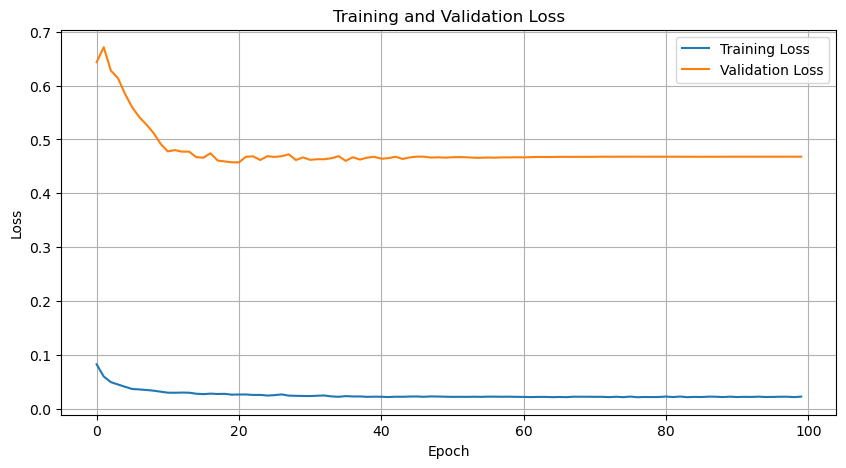

In [254]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("./figure/training_validation_loss.pdf", format="pdf")
plt.show()

In [255]:
def predictions(model, train_loader, test_loader):
    result = np.zeros(
        (
            (len(train_loader.dataset) + len(test_loader.dataset)) // n_locations,
            n_locations,
            2,
        )
    )

    def get_result(result, loader):
        model.eval()
        with torch.no_grad():
            for i, (X_batch, y_batch, loc_batch, time_batch) in enumerate(loader):
                curr_batch_size = X_batch.shape[0]
                X_batch, y_batch, loc_batch = (
                    X_batch.to(device),
                    y_batch.to(device),
                    loc_batch.to(device),
                )
                h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
                c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
                score, (_, _) = model(X_batch, loc_batch, h, c)
                score = score.reshape(curr_batch_size)
                result[time_batch, loc_batch.cpu().numpy(), 0] = score.cpu().numpy()
                result[time_batch, loc_batch.cpu().numpy(), 1] = y_batch.cpu().numpy()

    get_result(result, train_loader)
    get_result(result, test_loader)
    return result

In [ ]:
pred_model = CrimeLSTM(
    num_size, cat_size, hidden_size, embed_dim, num_layers, output_size, dropout
).to(device)
pred_model.load_state_dict(torch.load(best_model_path, weights_only=False))
result = predictions(model, train_loader, test_loader)
result_unscaled = np.zeros(result.shape)
result_unscaled[:, :, 0] = scaler_ls[0].inverse_transform(result[:, :, 0])
result_unscaled[:, :, 1] = scaler_ls[0].inverse_transform(result[:, :, 1])
result_unscaled = np.round(result_unscaled).astype(int)
result_df = data.copy()
result_df["lstm_pred"] = np.nan
for i in range(len(result_unscaled)):
    for j in range(len(result_unscaled[i])):
        result_df.loc[
            (result_df["time_idx"] == i + seq_length)
            & (result_df["location_idx"] == j),
            "lstm_pred",
        ] = result_unscaled[i, j, 0]

In [257]:
result_df = result_df[result_df["time_idx"] > seq_length - 1]
result_df.to_csv("./data/lstm_predictions.csv", index=False)

In [258]:
result_df[
    [
        "Year",
        "Month",
        "location_id",
        "time_id",
        "time_idx",
        "location_idx",
        "crime_count",
        "lstm_pred",
    ]
].head(12)

,Year,Month,location_id,time_id,time_idx,location_idx,crime_count,lstm_pred
12,2019,1,1,24229,12,0,27,19.0
13,2019,2,1,24230,13,0,10,18.0
14,2019,3,1,24231,14,0,11,16.0
15,2019,4,1,24232,15,0,20,15.0
16,2019,5,1,24233,16,0,27,19.0
17,2019,6,1,24234,17,0,22,24.0
18,2019,7,1,24235,18,0,29,26.0
19,2019,8,1,24236,19,0,27,27.0
20,2019,9,1,24237,20,0,28,25.0
21,2019,10,1,24238,21,0,32,24.0


In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [260]:
def weighted_mape(y_true, y_pred):
    """Calculate Weighted Mean Absolute Percentage Error"""
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100


y_true = result_df["crime_count"].values
y_pred = result_df["lstm_pred"].values
y_train_true = result_df[result_df["time_idx"] < train_size + seq_len]["crime_count"]
y_train_pred = result_df[result_df["time_idx"] < train_size + seq_len]["lstm_pred"]
y_test_true = result_df[result_df["time_idx"] >= train_size + seq_len]["crime_count"]
y_test_pred = result_df[result_df["time_idx"] >= train_size + seq_len]["lstm_pred"]
mae_train = mean_absolute_error(y_train_true, y_train_pred)
mae_test = mean_absolute_error(y_test_true, y_test_pred)
rmse_train = root_mean_squared_error(y_train_true, y_train_pred)
rmse_test = root_mean_squared_error(y_test_true, y_test_pred)
r2_train = r2_score(y_train_true, y_train_pred)
r2_test = r2_score(y_test_true, y_test_pred)
train_mean_value = np.mean(y_train_true)
test_mean_value = np.mean(y_test_true)
wmae_train = weighted_mape(y_train_true, y_train_pred)
wmae_test = weighted_mape(y_test_true, y_test_pred)

print(
    f"Train MAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}, Weighted MAE Percentage: {wmae_train:.4f}%"
)
print(
    f"Test MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}, Normalized MAE Percentage: {wmae_test:.4f}%"
)

Train MAE: 42.1528, RMSE: 117.1061, R2: 0.9958, Weighted MAE Percentage: 6.1626%
Test MAE: 49.5000, RMSE: 142.9673, R2: 0.9941, Normalized MAE Percentage: 6.8076%


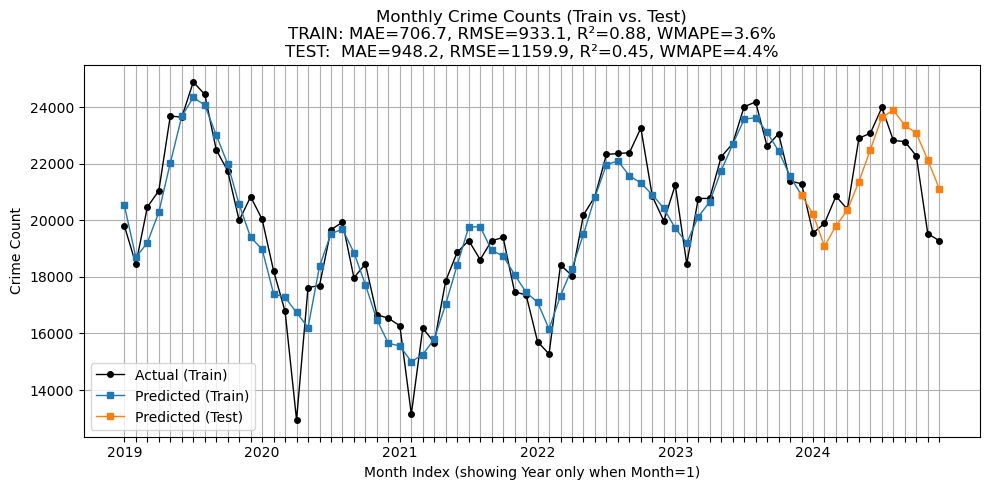

In [261]:
monthly_agg = result_df.groupby(["Year", "Month"], as_index=False).agg(
    {"crime_count": "sum", "lstm_pred": "sum"}
)

monthly_agg.sort_values(["Year", "Month"], inplace=True)

y_true = monthly_agg["crime_count"].values
y_pred = monthly_agg["lstm_pred"].values

x_vals = np.arange(len(monthly_agg))

cutoff = train_size
train_mask = x_vals < cutoff
test_mask = x_vals >= cutoff - 1
y_true_train, y_pred_train = y_true[train_mask], y_pred[train_mask]
y_true_test, y_pred_test = y_true[test_mask], y_pred[test_mask]

mae_train = mean_absolute_error(y_true_train, y_pred_train)
rmse_train = root_mean_squared_error(y_true_train, y_pred_train)
r2_train = r2_score(y_true_train, y_pred_train)
mape_train = weighted_mape(y_true_train, y_pred_train)

mae_test = mean_absolute_error(y_true_test, y_pred_test)
rmse_test = root_mean_squared_error(y_true_test, y_pred_test)
r2_test = r2_score(y_true_test, y_pred_test)
mape_test = weighted_mape(y_true_test, y_pred_test)
labels = []
for _, row in monthly_agg.iterrows():
    year = row["Year"]
    month = row["Month"]
    if month == 1:
        labels.append(int(year))  # show the year for January
    else:
        labels.append("")  # show empty for other months
plt.figure(figsize=(10, 5))

# Actual - Train portion
plt.plot(
    x_vals,
    y_true,
    marker="o",
    label="Actual (Train)",
    color="black",
    markersize=4,
    linewidth=1,
)
plt.plot(
    x_vals[train_mask],
    y_pred[train_mask],
    marker="s",
    label="Predicted (Train)",
    markersize=4,
    linewidth=1,
)
plt.plot(
    x_vals[test_mask],
    y_pred[test_mask],
    marker="s",
    label="Predicted (Test)",
    linestyle="-",
    markersize=4,
    linewidth=1,
)

plt.title(
    "Monthly Crime Counts (Train vs. Test)\n"
    "TRAIN: "
    f"MAE={mae_train:.1f}, RMSE={rmse_train:.1f}, R²={r2_train:.2f}, WMAPE={mape_train:.1f}%\n"
    "TEST:  "
    f"MAE={mae_test:.1f}, RMSE={rmse_test:.1f}, R²={r2_test:.2f}, WMAPE={mape_test:.1f}%"
)

plt.xlabel("Month Index (showing Year only when Month=1)")
plt.ylabel("Crime Count")
plt.xticks(x_vals, labels, rotation=0)  # Use custom labels
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [262]:
result_df[["location_id", "location_name"]]
idx2location = pd.Series(
    result_df["location_name"].unique(), index=result_df["location_idx"].unique()
).to_dict()

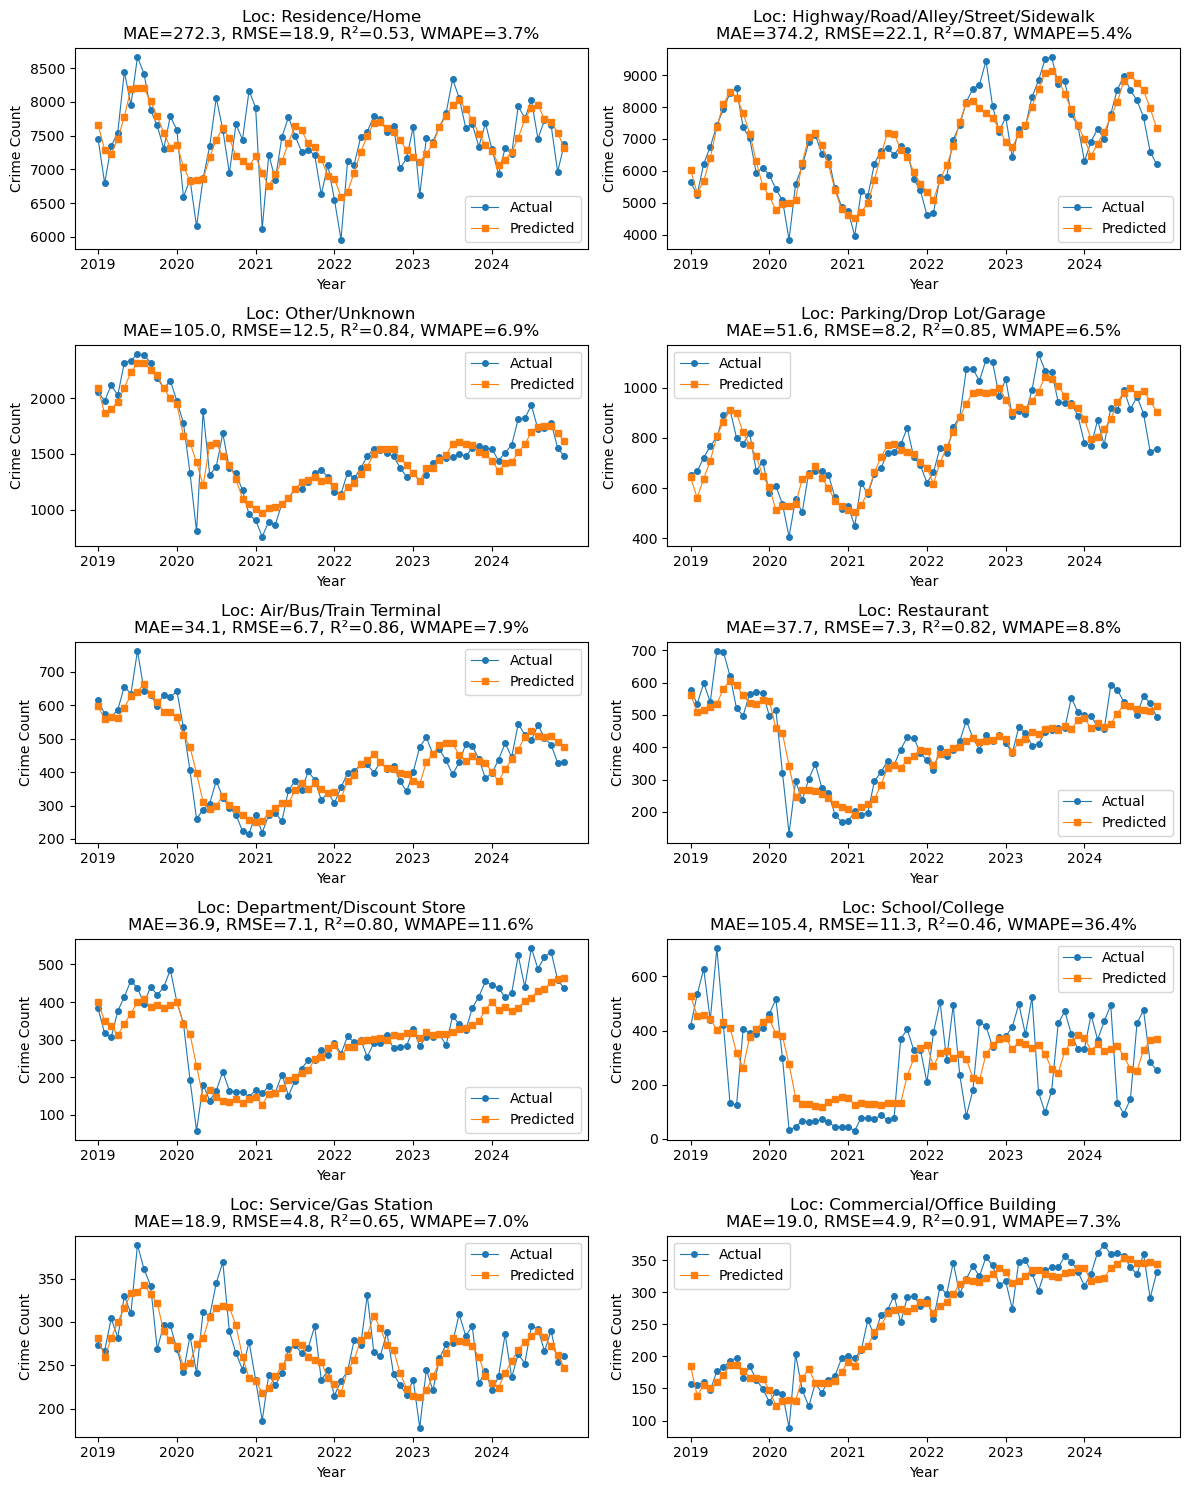

In [263]:
df = result_df.copy()
df.sort_values(["location_idx", "Year", "Month"], inplace=True)
total_by_loc = (
    df.groupby("location_idx")["crime_count"].sum().sort_values(ascending=False)
)
top_locations = total_by_loc.index[:10]
df_top = df[df["location_idx"].isin(top_locations)].copy()
df_top.sort_values(["location_idx", "Year", "Month"], inplace=True)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
axes = axes.flatten()
for i, loc in enumerate(top_locations):
    df_loc = df_top[df_top["location_idx"] == loc].copy()
    df_loc.sort_values(["Year", "Month"], inplace=True)
    df_loc.reset_index(drop=True, inplace=True)  # reset index so x-axis is 0, 1, 2, ...
    x_vals = df_loc.index  # Each index represents one month
    actual = df_loc["crime_count"].values
    predicted = df_loc["lstm_pred"].values
    mae_val = mean_absolute_error(actual, predicted)
    rmse_val = np.sqrt(root_mean_squared_error(actual, predicted))
    r2_val = r2_score(actual, predicted)
    wmape = weighted_mape(actual, predicted)
    ax = axes[i]
    ax.plot(x_vals, actual, marker="o", markersize=4, linewidth=0.8, label="Actual")
    ax.plot(
        x_vals, predicted, marker="s", markersize=4, linewidth=0.8, label="Predicted"
    )
    ax.set_title(
        f"Loc: {idx2location[loc]}\nMAE={mae_val:.1f}, RMSE={rmse_val:.1f}, R²={r2_val:.2f}, WMAPE={wmape:.1f}%"
    )
    ax.set_xlabel("Year")
    ax.set_ylabel("Crime Count")
    unique_years = df_loc["Year"].unique()
    tick_positions = []
    tick_labels = []
    for year in unique_years:
        pos = df_loc[df_loc["Year"] == year].index[0]
        tick_positions.append(pos)
        tick_labels.append(str(year))
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.legend()

plt.tight_layout()
plt.show()